In [1]:
# package imports 
import polars as pl
from pathlib import Path

# Energy Data Analytics - Trading Analytics Example
This example should show, how in general trading analytics can be employed to develop a deeper understanding of the market and even find trading strategy. The model is based on the stack model discussed in class.

## Model Approach
Our approach here is the following: 
- Model the stack 
- Model the renewable forecast distribution at the day ahead auction 
- Combine the two to calculate a "fair" price, which we can then use to open positions on IDA1 and close them on intraday

## Stack Modelling
As we learned, to model the stack we need to know two attributes of each conventional power plant: The installed capacity and the marginal production costs.
Anyhow, Marginal production costs of conventional power plants are not generally known. To model the stack we will use the actual production data for each german power plant over one week and observe at which prices it was running, to find the marginal production costs.

In [2]:
# import data
data_dir = Path("Data/actual_production_per_plant")
csv_files = list(data_dir.glob("*.csv"))

In [3]:
# Import prices data
prices_df = pl.read_csv("Data/prices/prices2025.csv", null_values=["n/e", ""])

# Add datetime column by parsing the first part of "MTU (CET/CEST)"
prices_df = prices_df.with_columns(
    pl.col("MTU (CET/CEST)")
    .str.split(" - ")
    .list.get(0)
    .str.to_datetime(format="%d/%m/%Y %H:%M:%S")
    .alias("datetime")
)

# Resample to hourly resolution using average
prices_df = prices_df.group_by_dynamic(
    "datetime",
    every="1h"
).agg([
    pl.col("Day-ahead Price (EUR/MWh)").mean().alias("day_ahead_price"),
]).sort("datetime")

print(prices_df)

shape: (7_726, 2)
┌─────────────────────┬─────────────────┐
│ datetime            ┆ day_ahead_price │
│ ---                 ┆ ---             │
│ datetime[μs]        ┆ f64             │
╞═════════════════════╪═════════════════╡
│ 2025-01-01 00:00:00 ┆ 1.0225          │
│ 2025-01-01 01:00:00 ┆ 0.5425          │
│ 2025-01-01 02:00:00 ┆ -0.73875        │
│ 2025-01-01 03:00:00 ┆ -1.305          │
│ 2025-01-01 04:00:00 ┆ -3.255          │
│ …                   ┆ …               │
│ 2025-11-18 19:00:00 ┆ 127.5           │
│ 2025-11-18 20:00:00 ┆ 109.27375       │
│ 2025-11-18 21:00:00 ┆ 98.8925         │
│ 2025-11-18 22:00:00 ┆ 96.8725         │
│ 2025-11-18 23:00:00 ┆ 86.7975         │
└─────────────────────┴─────────────────┘


In [4]:
# Read and combine all CSV files
plant_production_df = pl.concat([pl.read_csv(file, null_values=["n/e", ""]) for file in csv_files])

# Add datetime column by parsing the first part of "Time Interval (CET/CEST)"
plant_production_df = plant_production_df.with_columns(
    pl.col("MTU (CET/CEST)")
    .str.split(" - ")
    .list.get(0)
    .str.to_datetime(format="%d/%m/%Y %H:%M")
    .alias("datetime")
)

# Select and rename columns, fill null values in generation
plant_production_df = plant_production_df.select([
    pl.col("datetime"),
    pl.col("Unit Name").alias("unit"),
    pl.col("Generation (MW)").fill_null(0).alias("generation")
])

# Join day_ahead_price to plant_production_df
plant_production_df = plant_production_df.join(
    prices_df.select(["datetime", "day_ahead_price"]),
    on="datetime",
    how="left"
)

print(plant_production_df)

shape: (17_808, 4)
┌─────────────────────┬────────────────────────┬────────────┬─────────────────┐
│ datetime            ┆ unit                   ┆ generation ┆ day_ahead_price │
│ ---                 ┆ ---                    ┆ ---        ┆ ---             │
│ datetime[μs]        ┆ str                    ┆ f64        ┆ f64             │
╞═════════════════════╪════════════════════════╪════════════╪═════════════════╡
│ 2025-11-03 00:00:00 ┆ GTHKW Nossener Bruecke ┆ 152.32     ┆ 76.40625        │
│ 2025-11-03 01:00:00 ┆ GTHKW Nossener Bruecke ┆ 152.35     ┆ 74.9625         │
│ 2025-11-03 02:00:00 ┆ GTHKW Nossener Bruecke ┆ 151.85     ┆ 71.265          │
│ 2025-11-03 03:00:00 ┆ GTHKW Nossener Bruecke ┆ 93.85      ┆ 70.38375        │
│ 2025-11-03 04:00:00 ┆ GTHKW Nossener Bruecke ┆ 151.72     ┆ 72.23125        │
│ …                   ┆ …                      ┆ …          ┆ …               │
│ 2025-11-09 19:00:00 ┆ RUHRORT-3              ┆ 0.0        ┆ 117.92875       │
│ 2025-11-09 20:00:00

In [5]:
# Get the marginal prices for each power plant
results = []

for unit_name in plant_production_df["unit"].unique():
    # Filter and sort by datetime
    unit_df = plant_production_df.filter(pl.col("unit") == unit_name).sort("datetime")

    #Round the generation of the power plant to the next 50MW to ignore small ramps etc
    unit_df = unit_df.with_columns(
        (pl.col("generation") / 50).ceil().mul(50).alias("generation")
    )
    
    # Skip if all generation values are zero
    if unit_df["generation"].max() == 0:
        continue

    # If all generation values are non-zero, marginal price is 0
    if unit_df["generation"].min() > 0:
        results.append({
            "unit": unit_name,
            "generation": unit_df["generation"].max(),
            "marginal_price": 0
        })
        continue
    
    # Create groups for consecutive non-zero generation periods
    # Mark where generation changes from 0 to non-zero or vice versa
    unit_df = unit_df.with_columns(
        (pl.col("generation") == 0).alias("is_zero")
    )
    
    # Create group ID that changes whenever we transition between 0 and non-zero
    unit_df = unit_df.with_columns(
        pl.col("is_zero").cum_sum().alias("group_id")
    )
    
    # Calculate average day_ahead_price for each group
    group_avg = unit_df.group_by("group_id").agg([
        pl.col("day_ahead_price").mean().alias("avg_price")
    ])

    # Join group_avg back to unit_df
    unit_df = unit_df.join(group_avg, on="group_id", how="left")
    
    unit_df = unit_df.filter(pl.col("generation")==pl.col("generation").max())
    
    results.append({
            "unit": unit_name,
            "generation": unit_df["generation"].max(),
            "marginal_price": unit_df["avg_price"].min()
        })

# Convert results to dataframe
marginal_results_df = pl.DataFrame(results)

# Sort by marginal_price and add cumulated generation column
marginal_results_df = marginal_results_df.sort("marginal_price").with_columns(
    pl.col("generation").cum_sum().alias("cumulated_generation")
)

print(marginal_results_df)

shape: (77, 4)
┌──────────────────────────┬────────────┬────────────────┬──────────────────────┐
│ unit                     ┆ generation ┆ marginal_price ┆ cumulated_generation │
│ ---                      ┆ ---        ┆ ---            ┆ ---                  │
│ str                      ┆ f64        ┆ f64            ┆ f64                  │
╞══════════════════════════╪════════════╪════════════════╪══════════════════════╡
│ Neurath F                ┆ 1050.0     ┆ 0.0            ┆ 1050.0               │
│ HKW Wedel Block 1        ┆ 100.0      ┆ 0.0            ┆ 1150.0               │
│ GuD Marzahn              ┆ 250.0      ┆ 0.0            ┆ 1400.0               │
│ Rheinkraftwerk Iffezheim ┆ 150.0      ┆ 0.0            ┆ 1550.0               │
│ KW Boxberg Block Q       ┆ 850.0      ┆ 0.0            ┆ 2400.0               │
│ …                        ┆ …          ┆ …              ┆ …                    │
│ Weisweiler VGT - BI. G   ┆ 200.0      ┆ 117.10125      ┆ 28500.0              │
│

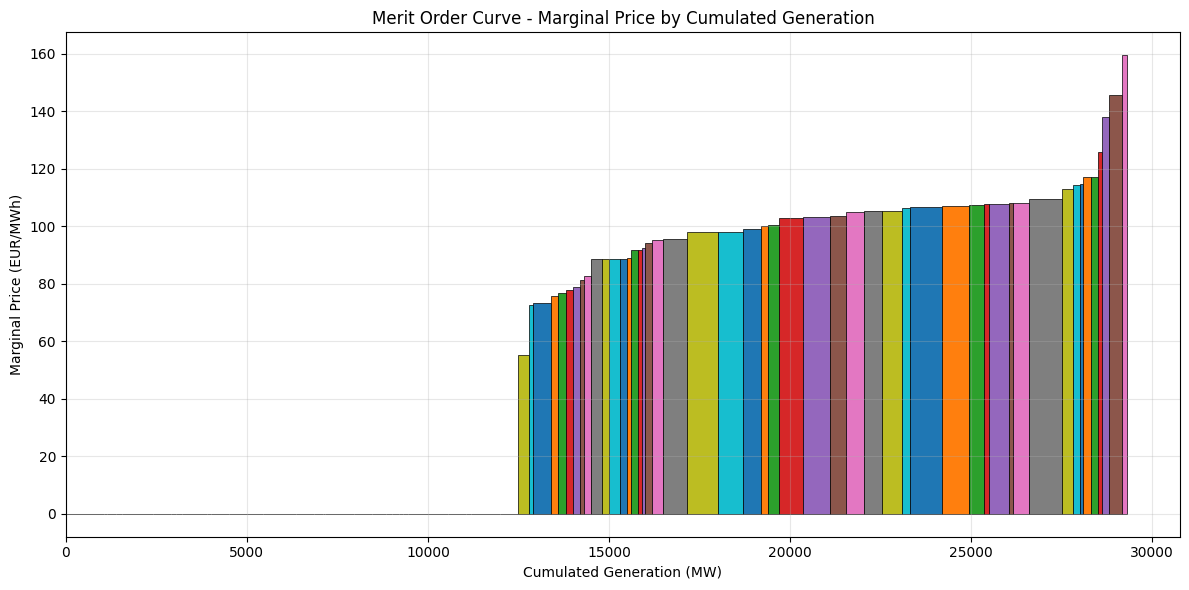

In [6]:
# Create a stacked bar chart
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))

# Create bars for each unit
for i in range(len(marginal_results_df)):
    row = marginal_results_df.row(i, named=True)
    # Calculate the starting position (previous cumulated generation)
    x_start = row["cumulated_generation"] - row["generation"]
    
    ax.barh(
        y=row["marginal_price"] / 2,  # Center the bar at half the marginal price
        width=row["generation"],
        left=x_start,
        height=row["marginal_price"],  # Bar extends from 0 to marginal_price
        label=row["unit"],
        edgecolor='black',
        linewidth=0.5
    )

ax.set_xlabel("Cumulated Generation (MW)")
ax.set_ylabel("Marginal Price (EUR/MWh)")
ax.set_title("Merit Order Curve - Marginal Price by Cumulated Generation")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Renewable Forecast Error Analysis
Point forecasts are usefull and the industry standard, but getting probability distributions is often a powerful tool in power markets, as the price sensitivity of the stack is not symetrical. So to figure out if there is a bigger price movement for either under or over estimation, we first have to figure out how wrong our forecasts are in general. This can easily be calculated using historical forecast data and actuals, to see the distribution of the error (should be normal distributed if the forecast is not totally off).

In [7]:
# import Data
# Import renewable energy data
wind_onshore = pl.read_csv("Data/renewables/onshore_wind2025.csv", null_values=["n/e", "", "N/A"])
wind_offshore = pl.read_csv("Data/renewables/offshore_wind2025.csv", null_values=["n/e", "", "N/A"])
solar = pl.read_csv("Data/renewables/solar2025.csv", null_values=["n/e", "", "N/A"])

# Process wind_onshore
wind_onshore = wind_onshore.with_columns(
    pl.col("MTU (CET/CEST)")
    .str.split(" - ")
    .list.get(0)
    .str.to_datetime(format="%d/%m/%Y %H:%M:%S")
    .alias("datetime")
).select([
    pl.col("datetime"),
    pl.col("Day-ahead (MW)").alias("dayahead"),
    pl.col("Actual (MW)").alias("actual")
])

# Process wind_offshore
wind_offshore = wind_offshore.with_columns(
    pl.col("MTU (CET/CEST)")
    .str.split(" - ")
    .list.get(0)
    .str.to_datetime(format="%d/%m/%Y %H:%M:%S")
    .alias("datetime")
).select([
    pl.col("datetime"),
    pl.col("Day-ahead (MW)").alias("dayahead"),
    pl.col("Actual (MW)").alias("actual")
])

# Process solar
solar = solar.with_columns(
    pl.col("MTU (CET/CEST)")
    .str.split(" - ")
    .list.get(0)
    .str.to_datetime(format="%d/%m/%Y %H:%M:%S")
    .alias("datetime")
).select([
    pl.col("datetime"),
    pl.col("Day-ahead (MW)").alias("dayahead"),
    pl.col("Actual (MW)").alias("actual")
])

# Combine all renewables into one dataframe by summing day-ahead and actual values
renewables = wind_onshore.join(wind_offshore, on="datetime", suffix="_offshore")
renewables = renewables.join(solar, on="datetime", suffix="_solar")

# Sum all day-ahead forecasts and actuals
renewables = renewables.with_columns([
    (pl.col("dayahead") + pl.col("dayahead_offshore") + pl.col("dayahead_solar")).alias("dayahead_total"),

    (pl.col("actual") + pl.col("actual_offshore") + pl.col("actual_solar")).alias("actual_total")

])

renewables = renewables.select(
    pl.col('datetime'), pl.col('dayahead_total'), pl.col('actual_total')
)

# Filter renewables to only include data before 2025-11-09, as we use this as a testing day 
renewables = renewables.filter(pl.col("datetime") < pl.datetime(2025, 11, 9))
renewables = renewables.filter(pl.col("datetime") >= pl.datetime(2025, 10, 9))

print(renewables)

shape: (2_972, 3)
┌─────────────────────┬────────────────┬──────────────┐
│ datetime            ┆ dayahead_total ┆ actual_total │
│ ---                 ┆ ---            ┆ ---          │
│ datetime[μs]        ┆ f64            ┆ f64          │
╞═════════════════════╪════════════════╪══════════════╡
│ 2025-10-09 00:00:00 ┆ 6299.95        ┆ 5771.87      │
│ 2025-10-09 00:15:00 ┆ 6308.46        ┆ 5763.43      │
│ 2025-10-09 00:30:00 ┆ 6321.57        ┆ 5492.36      │
│ 2025-10-09 00:45:00 ┆ 6328.92        ┆ 5377.11      │
│ 2025-10-09 01:00:00 ┆ 6338.54        ┆ 5276.52      │
│ …                   ┆ …              ┆ …            │
│ 2025-11-08 22:45:00 ┆ 1418.26        ┆ 1821.29      │
│ 2025-11-08 23:00:00 ┆ 1460.87        ┆ 1782.76      │
│ 2025-11-08 23:15:00 ┆ 1498.16        ┆ 1733.19      │
│ 2025-11-08 23:30:00 ┆ 1535.79        ┆ 1715.36      │
│ 2025-11-08 23:45:00 ┆ 1573.3         ┆ 1680.35      │
└─────────────────────┴────────────────┴──────────────┘


In [8]:
# Calculate forecast errors and error distributions
import numpy as np

# Calculate error (actual - dayahead) for combined renewables
renewables = renewables.with_columns(
    (pl.col("actual_total") - pl.col("dayahead_total")).alias("error")
)

# Calculate percentiles (10th, 20th, ..., 90th, 100th)
percentiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Store error percentiles in a dictionary for later use
error_percentiles = {}

print("=" * 80)
print("COMBINED RENEWABLES - Error Distribution by Percentile")
print("=" * 80)
for p in percentiles:
    error_value = renewables["error"].quantile(p)
    error_percentiles[p] = error_value
    print(f"{int(p*100):3d}% of the time, the forecast error is <= {error_value:>8.2f} MW")

# Summary statistics
print("\n" + "=" * 80)
print("SUMMARY STATISTICS")
print("=" * 80)
print(f"\nCombined Renewables (Wind Onshore + Wind Offshore + Solar):")
print(f"  Mean Error:   {renewables['error'].mean():>8.2f} MW")
print(f"  Std Dev:      {renewables['error'].std():>8.2f} MW")
print(f"  Min Error:    {renewables['error'].min():>8.2f} MW")
print(f"  Max Error:    {renewables['error'].max():>8.2f} MW")

print(f"\nError percentiles saved to 'error_percentiles' dictionary")


COMBINED RENEWABLES - Error Distribution by Percentile
 10% of the time, the forecast error is <= -2650.77 MW
 20% of the time, the forecast error is <= -1785.73 MW
 30% of the time, the forecast error is <= -1185.22 MW
 40% of the time, the forecast error is <=  -689.38 MW
 50% of the time, the forecast error is <=  -178.20 MW
 60% of the time, the forecast error is <=   377.04 MW
 70% of the time, the forecast error is <=   933.62 MW
 80% of the time, the forecast error is <=  1682.63 MW
 90% of the time, the forecast error is <=  2484.65 MW

SUMMARY STATISTICS

Combined Renewables (Wind Onshore + Wind Offshore + Solar):
  Mean Error:    -158.03 MW
  Std Dev:       2133.55 MW
  Min Error:    -11318.16 MW
  Max Error:     5310.74 MW

Error percentiles saved to 'error_percentiles' dictionary


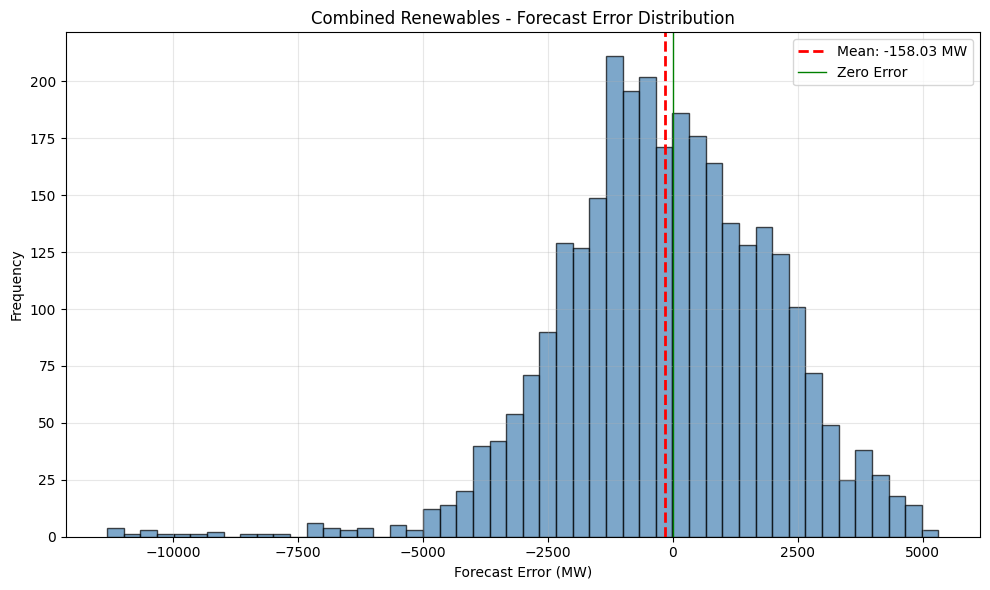

In [9]:
# Visualize error distribution
fig, ax = plt.subplots(figsize=(10, 6))

# Combined Renewables
ax.hist(renewables["error"], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax.axvline(renewables["error"].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {renewables["error"].mean():.2f} MW')
ax.axvline(0, color='green', linestyle='-', linewidth=1, label='Zero Error')
ax.set_xlabel('Forecast Error (MW)')
ax.set_ylabel('Frequency')
ax.set_title('Combined Renewables - Forecast Error Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## The Trading Idea

In [10]:
# Calculate equally probable forecast scenarios
# For a given day-ahead forecast, we can calculate 10 equally likely scenarios
# by adding each percentile error to the forecast

# Example: Let's take a specific forecast value (e.g., mean of day-ahead forecasts)
example_forecast = renewables["dayahead_total"].mean()

print("=" * 80)
print("EQUALLY PROBABLE FORECAST SCENARIOS")
print("=" * 80)
print(f"\nDay-ahead Forecast: {example_forecast:>8.2f} MW\n")
print(f"{'Percentile':<12} {'Error (MW)':<15} {'Predicted Actual (MW)':<25}")
print("-" * 80)

# Create a list to store scenarios
forecast_scenarios = []

for p in percentiles:
    error = error_percentiles[p]
    predicted_actual = example_forecast + error
    forecast_scenarios.append({
        'percentile': p,
        'error': error,
        'predicted_actual': predicted_actual
    })
    print(f"{int(p*100):>3d}%        {error:>10.2f}      {predicted_actual:>15.2f}")

print("\n" + "=" * 80)
print("INTERPRETATION:")
print("=" * 80)
print("Each scenario represents a 10% probability range:")
print("- There's a 10% chance actual production will be between 0% and 10% scenarios")
print("- There's a 10% chance actual production will be between 10% and 20% scenarios")
print("- And so on...")
print("\nThese scenarios are used to:")
print("1. Calculate expected prices for each scenario using the merit order curve")
print("2. Assess risk-adjusted positions")
print("3. Optimize trading strategies across probability-weighted outcomes")

EQUALLY PROBABLE FORECAST SCENARIOS

Day-ahead Forecast: 26418.16 MW

Percentile   Error (MW)      Predicted Actual (MW)    
--------------------------------------------------------------------------------
 10%          -2650.77             23767.39
 20%          -1785.73             24632.43
 30%          -1185.22             25232.94
 40%           -689.38             25728.78
 50%           -178.20             26239.96
 60%            377.04             26795.20
 70%            933.62             27351.78
 80%           1682.63             28100.79
 90%           2484.65             28902.81

INTERPRETATION:
Each scenario represents a 10% probability range:
- There's a 10% chance actual production will be between 0% and 10% scenarios
- There's a 10% chance actual production will be between 10% and 20% scenarios
- And so on...

These scenarios are used to:
1. Calculate expected prices for each scenario using the merit order curve
2. Assess risk-adjusted positions
3. Optimize trading 

## Example: Possible Outcomes on the Merit Order Curve for a Given Price

Given a specific market price (e.g., 100€), we can determine what demand levels correspond to this price across different renewable forecast scenarios. Each scenario represents a different forecast error percentile, resulting in different conventional demand levels and thus different positions on the merit order curve.

In [11]:
# Given a price, find possible outcomes on the merit order curve
# across different renewable forecast error scenarios

# Set the target price
target_price = 95.0  # EUR/MWh

# Get the reference conventional demand from the merit order curve
# This represents the baseline demand that would occur at the day-ahead forecast
# Find the demand level where marginal_price is closest to target_price
reference_demand_row = marginal_results_df.with_columns(
    (pl.col("marginal_price") - target_price).abs().alias("price_diff")
).sort("price_diff").head(1)

reference_demand = reference_demand_row["cumulated_generation"][0]

print("=" * 80)
print(f"MERIT ORDER OUTCOMES FOR PRICE = {target_price}€/MWh")
print("=" * 80)
print(f"\nReference Demand (from merit order): {reference_demand:,.0f} MW")
print(f"Day-ahead Renewable Forecast: {example_forecast:,.2f} MW\n")
print(f"{'Percentile':<12} {'Renewable Error':<18} {'Adjusted Demand':<20} {'Fair Price':<15}")
print("-" * 80)

# Store results for visualization
scenario_prices = []
fair_price_total = 0

for scenario in forecast_scenarios:
    # Error represents the difference: actual - forecast
    # If error is negative: actual < forecast → more conventional demand needed
    # If error is positive: actual > forecast → less conventional demand needed
    error = scenario['error']
    
    # Adjusted demand: subtract the error from reference demand
    # Negative error → increases demand, Positive error → decreases demand
    adjusted_demand = reference_demand - error
    
    # Find the fair price at this adjusted demand level on the merit order curve
    # This is where cumulated_generation >= adjusted_demand
    fair_price_row = marginal_results_df.filter(
        pl.col("cumulated_generation") >= adjusted_demand
    ).sort("cumulated_generation").head(1)
    
    if len(fair_price_row) > 0:
        fair_price = fair_price_row["marginal_price"][0]
    else:
        fair_price = marginal_results_df["marginal_price"].max()  # Price cap

    fair_price_total += fair_price
    
    scenario_prices.append({
        'percentile': scenario['percentile'],
        'error': error,
        'adjusted_demand': adjusted_demand,
        'fair_price': fair_price
    })
    
    print(f"{int(scenario['percentile']*100):>3d}%        "
          f"{error:>10.2f} MW      "
          f"{adjusted_demand:>12.2f} MW      "
          f"{fair_price:>10.2f}€")

fair_price_total = round(fair_price_total/len(forecast_scenarios),2)

print("\n" + "=" * 80)
print("INTERPRETATION:")
print("=" * 80)
print(f"If the market price is {target_price}€/MWh:")
print(f"- Different renewable forecast errors shift the conventional demand")
print(f"- Negative errors (underproduction) → higher demand → higher fair price")
print(f"- Positive errors (overproduction) → lower demand → lower fair price")
print(f"- Each adjusted demand level maps to a different 'fair price' on the merit order")
print(f"- The spread between market price ({target_price}€) and fair price determines profitability")
print(f"\nTrading Strategy:")
print(f'- The fair price is {fair_price_total}€')
print(f"- If fair price < {target_price}€: Market is expensive → Sell position is profitable")
print(f"- If fair price > {target_price}€: Market is cheap → Buy position is profitable")
print(f"- Expected value considers all scenarios weighted by their probability (10% each)")

MERIT ORDER OUTCOMES FOR PRICE = 95.0€/MWh

Reference Demand (from merit order): 16,500 MW
Day-ahead Renewable Forecast: 26,418.16 MW

Percentile   Renewable Error    Adjusted Demand      Fair Price     
--------------------------------------------------------------------------------
 10%          -2650.77 MW          19150.77 MW           99.09€
 20%          -1785.73 MW          18285.73 MW           97.96€
 30%          -1185.22 MW          17685.22 MW           97.83€
 40%           -689.38 MW          17189.38 MW           97.83€
 50%           -178.20 MW          16678.20 MW           95.57€
 60%            377.04 MW          16122.96 MW           94.17€
 70%            933.62 MW          15566.38 MW           88.93€
 80%           1682.63 MW          14817.37 MW           88.59€
 90%           2484.65 MW          14015.35 MW           78.95€

INTERPRETATION:
If the market price is 95.0€/MWh:
- Different renewable forecast errors shift the conventional demand
- Negative errors (u

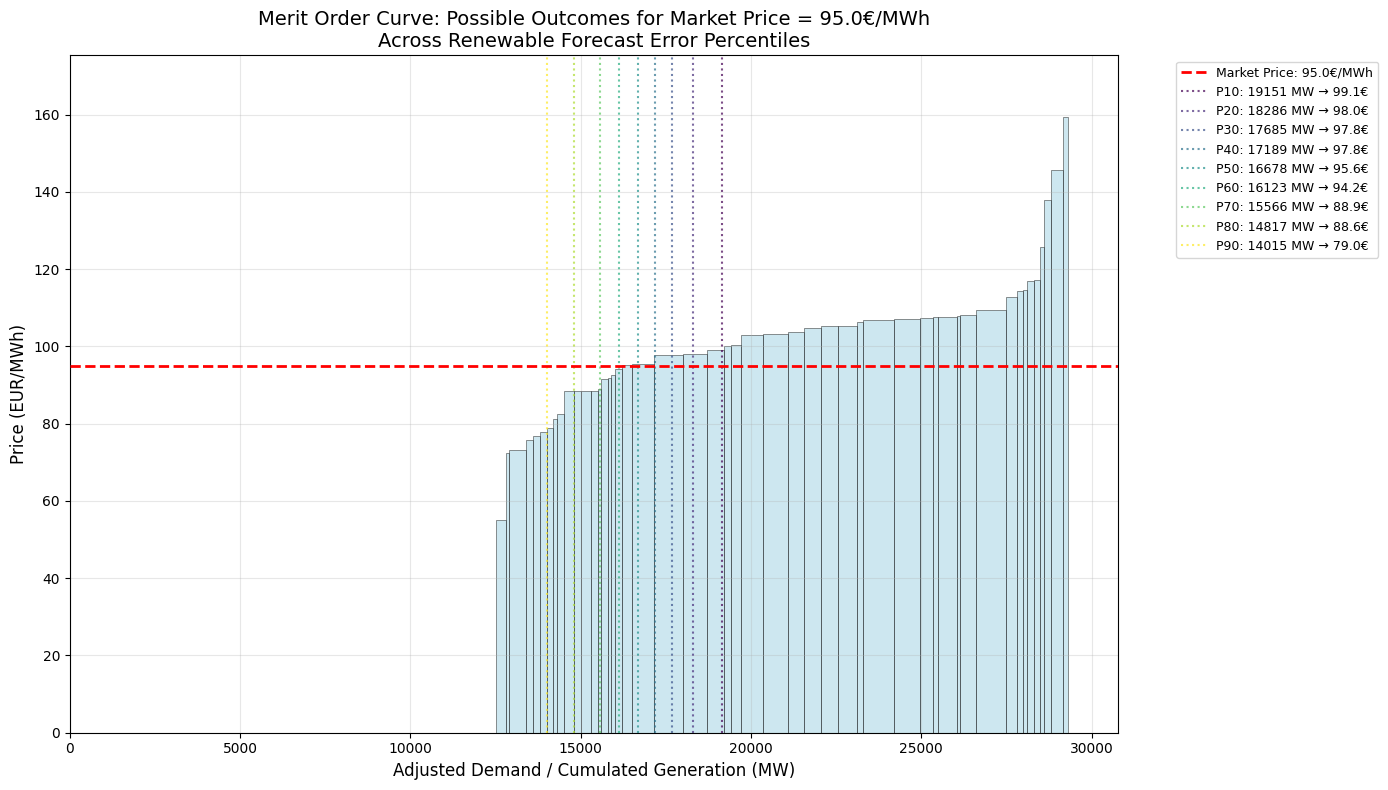

In [12]:
# Visualize the possible outcomes on the merit order curve
fig, ax = plt.subplots(figsize=(14, 8))

# Plot the merit order curve (same as before)
for i in range(len(marginal_results_df)):
    row = marginal_results_df.row(i, named=True)
    x_start = row["cumulated_generation"] - row["generation"]
    
    ax.barh(
        y=row["marginal_price"] / 2,
        width=row["generation"],
        left=x_start,
        height=row["marginal_price"],
        edgecolor='black',
        linewidth=0.5,
        alpha=0.6,
        color='lightblue'
    )

# Add horizontal line for the target price
ax.axhline(y=target_price, color='red', linestyle='--', linewidth=2, 
           label=f'Market Price: {target_price}€/MWh', zorder=5)

# Plot vertical lines for each scenario's adjusted demand
colors = plt.cm.viridis(np.linspace(0, 1, len(scenario_prices)))
for i, scenario in enumerate(scenario_prices):
    ax.axvline(x=scenario['adjusted_demand'], 
               color=colors[i], 
               linestyle=':', 
               linewidth=1.5,
               alpha=0.7,
               label=f"P{int(scenario['percentile']*100)}: {scenario['adjusted_demand']:.0f} MW → {scenario['fair_price']:.1f}€")

ax.set_xlabel("Adjusted Demand / Cumulated Generation (MW)", fontsize=12)
ax.set_ylabel("Price (EUR/MWh)", fontsize=12)
ax.set_title(f"Merit Order Curve: Possible Outcomes for Market Price = {target_price}€/MWh\nAcross Renewable Forecast Error Percentiles", fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax.set_xlim(left=0)
ax.set_ylim(bottom=0, top=max(target_price * 1.2, marginal_results_df["marginal_price"].max() * 1.1))

plt.tight_layout()
plt.show()

## Fair Price Calculation for 09.11.2025

Calculate the expected fair price for each hour on 09.11.2025 based on the day-ahead renewable forecast and the error distribution.

In [ ]:
def calculate_fair_price(target_price, marginal_results_df):
    # Get the reference conventional demand from the merit order curve
    # This represents the baseline demand that would occur at the day-ahead forecast
    # Find the demand level where marginal_price is closest to target_price
    reference_demand_row = marginal_results_df.with_columns(
        (pl.col("marginal_price") - target_price).abs().alias("price_diff")
    ).sort("price_diff").head(1)

    reference_demand = reference_demand_row["cumulated_generation"][0]

    # Store results for visualization
    fair_price_total = 0

    for scenario in forecast_scenarios:
        # Error represents the difference: actual - forecast
        # If error is negative: actual < forecast → more conventional demand needed
        # If error is positive: actual > forecast → less conventional demand needed
        error = scenario['error']
        
        # Adjusted demand: subtract the error from reference demand
        # Negative error → increases demand, Positive error → decreases demand
        adjusted_demand = reference_demand - error
        
        # Find the fair price at this adjusted demand level on the merit order curve
        # This is where cumulated_generation >= adjusted_demand
        fair_price_row = marginal_results_df.filter(
            pl.col("cumulated_generation") >= adjusted_demand
        ).sort("cumulated_generation").head(1)
         
        if len(fair_price_row) > 0:
            fair_price = fair_price_row["marginal_price"][0]
        else:
            fair_price = marginal_results_df["marginal_price"].max()  # Price cap

        fair_price_total += fair_price

    return round(fair_price_total/len(forecast_scenarios),2)

93.21
